[Reference](https://towardsdatascience.com/five-practical-applications-of-the-lstm-model-for-time-series-with-code-a7aac0aa85c0)

In [2]:
!pip install scalecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.9 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.19.9-py3-none-any.whl size=125805 sha256=2f5651a4ece097b83e1a0d21a41105701374a11063bfe265929ea7bdf486d7d1
  Stored in directory: /root/.cache/pip/wheels/c0/63/02/3dfe5b5cbdbffd10136943e110b6937714f71cb3047a48d0e5
Successfully built scalecast
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.Pipeline import Transformer, Reverter, Pipeline
from scalecast.util import (
    find_optimal_transformation,
    gen_rnn_grid,
    backtest_for_resid_matrix,
    get_backtest_resid_matrix,
    overwrite_forecast_intervals,
    infer_apply_Xvar_selection,
)
from scalecast import GridGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas_datareader as pdr

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Univariate Forecasting

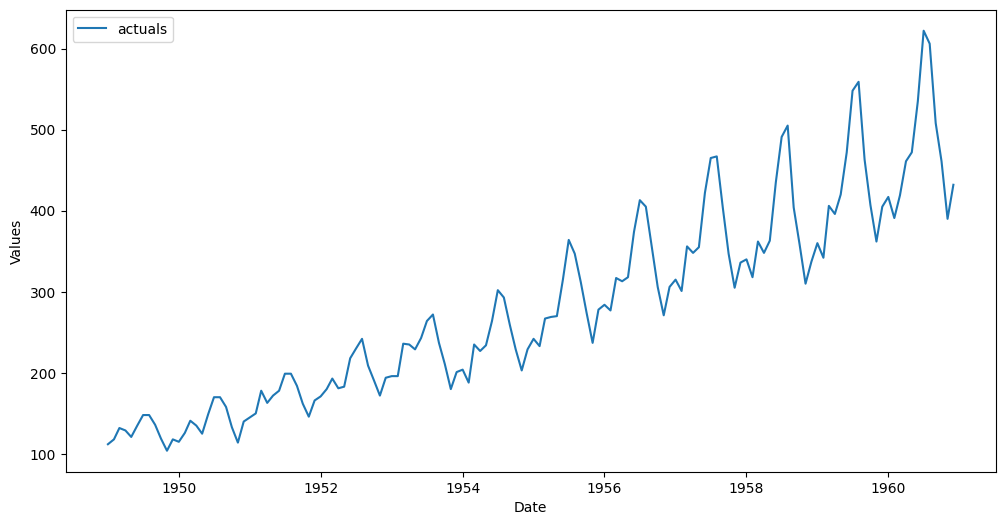

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/mikekeith52/scalecast-examples/main/lstm/AirPassengers.csv',parse_dates=['Month'])

f = Forecaster(
    y=data['#Passengers'],
    current_dates=data['Month'],
    future_dates = 24,
)

f.plot()
plt.show()

In [5]:
def forecaster(f):
    f.set_estimator('rnn')
    f.manual_forecast(
        lags = 18,
        layers_struct = [
            ('LSTM',{'units':36,'activation':'tanh'}),
        ],
        epochs=200,
        call_me = 'lstm',
    )

transformer = Transformer(
    transformers = [
        ('DetrendTransform',{'poly_order':2}),
        'DeseasonTransform',
    ],
)

reverter = Reverter(
    reverters = [
        'DeseasonRevert',
        'DetrendRevert',
    ],
    base_transformer = transformer,
)

pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f = pipeline.fit_predict(f)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3762
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3627 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3475 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3284 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3061
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2748 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2403  
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1956 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1875  
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1671
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1525 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1504
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1458
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1413 
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1379 
Epoch 16/20

# Multivariate Forecasting

In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/mikekeith52/scalecast-examples/main/lstm/avocado.csv')

In [7]:
# demand
vol = data.groupby('Date')['Total Volume'].sum()
# price
price = data.groupby('Date')['AveragePrice'].sum()

fvol = Forecaster(
    y = vol,
    current_dates = vol.index,
    test_length = 13,
    validation_length = 13,
    future_dates = 13,
    metrics = ['rmse','r2'],
)
fprice = Forecaster(
    y = price,
    current_dates = price.index,
    future_dates = 13,
)

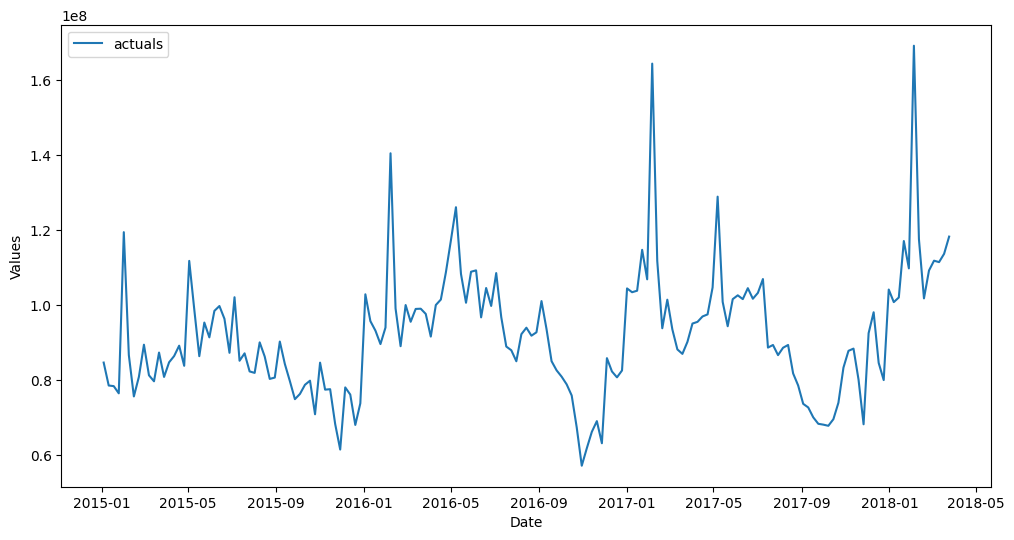

In [8]:
fvol.plot()
plt.show()

In [9]:
transformer, reverter = find_optimal_transformation(
    fvol,
    set_aside_test_set=True, # prevents leakage so we can benchmark the resulting models fairly
    return_train_only = True, # prevents leakage so we can benchmark the resulting models fairly
    verbose=True,
    detrend_kwargs=[
        {'loess':True},
        {'poly_order':1},
        {'ln_trend':True},
    ],
    m = 52, # what makes one seasonal cycle?
    test_length = 4,
)

Using mlr model to find the best transformation set on 1 test sets, each 4 in length.
All transformation tries will be evaluated with 52 lags.
Last transformer tried:
[]
Score (rmse): 10788435.4784998
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (rmse): 17367936.069693547
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (rmse): 12269036.469923053
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'ln_trend': True})]
Score (rmse): 12093617.597284118
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (rmse): 9289548.042079162
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'}), ('Transform', BoxcoxTransform, {'lmbda': -0.5})]
Score (rmse): 104

In [10]:
fprice = transformer.fit_transform(fprice)
fvol = transformer.fit_transform(fvol)

In [11]:
rnn_grid = gen_rnn_grid(
    layer_tries = 10,
    min_layer_size = 3,
    max_layer_size = 5,
    units_pool = [100],
    epochs = [100],
    dropout_pool = [0,0.05],
    validation_split=.2,
    callbacks=EarlyStopping(
      monitor='val_loss',
      patience=3,
    ),
    random_seed = 20,
) # creates a grid of hyperparameter values to tune the LSTM model

In [12]:
def forecaster(fvol,fprice):
    # naive forecast for benchmarking
    fvol.set_estimator('naive')
    fvol.manual_forecast()
    # univariate lstm model
    fvol.add_ar_terms(13) # the model will use 13 series lags
    fvol.set_estimator('rnn')
    fvol.ingest_grid(rnn_grid)
    fvol.tune()
    fvol.auto_forecast(call_me='lstm_univariate')
    # multivariate lstm model
    fvol.add_series(fprice.y,called='price')
    fvol.add_lagged_terms('price',lags=13,drop=True)
    fvol.ingest_grid(rnn_grid)
    fvol.tune()
    fvol.auto_forecast(call_me='lstm_multivariate')

In [13]:
forecaster(fvol=fvol,fprice=fprice)


output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 13, 1), dtype=float32, sparse=None, name=keras_tensor_4>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 13, 1), dtype=float32, sparse=None, name=keras_tensor_5>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 13, 1), dtype=float32, sparse=None, name=keras_tensor_6>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 13, 1), dtype=float32, sparse=None, name=keras_tensor_7>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 13, 1), dtype=float32, sparse=None

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6337
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  



output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 26, 1), dtype=float32, sparse=None, name=keras_tensor_22>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 26, 1), dtype=float32, sparse=None, name=keras_tensor_23>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 26, 1), dtype=float32, sparse=None, name=keras_tensor_24>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 26, 1), dtype=float32, sparse=None, name=keras_tensor_25>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 26, 1), dtype=float32, sparse=

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6915


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


In [14]:
fvol = reverter.fit_transform(fvol)

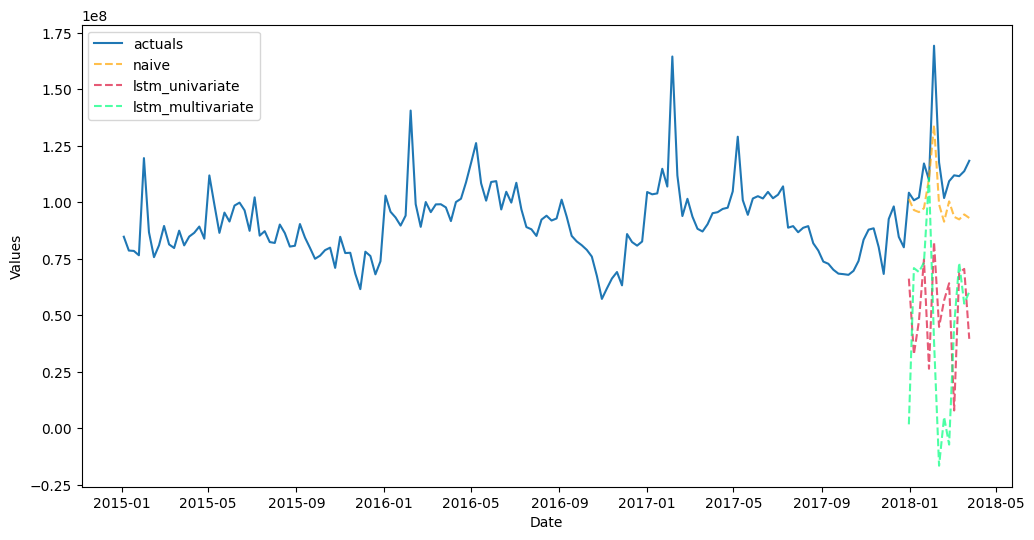

In [15]:
fvol.plot_test_set(order_by='TestSetRMSE')
plt.savefig('LSTM MV test results.png')
plt.show()

In [16]:
pd.options.display.float_format = '{:,.4f}'.format
summ = fvol.export('model_summaries',determine_best_by='TestSetRMSE')
summ[['ModelNickname','TestSetRMSE','TestSetR2']]

,ModelNickname,TestSetRMSE,TestSetR2
0,naive,"17,403,456.6059",-0.0646
1,lstm_univariate,"65,348,534.2742",-14.0100
2,lstm_multivariate,"80,938,480.8530",-22.0260


In [17]:
summ[['ModelNickname','HyperParams']].style.set_properties(height = 5)

,ModelNickname,HyperParams
0,naive,{}
1,lstm_univariate,{}
2,lstm_multivariate,{}


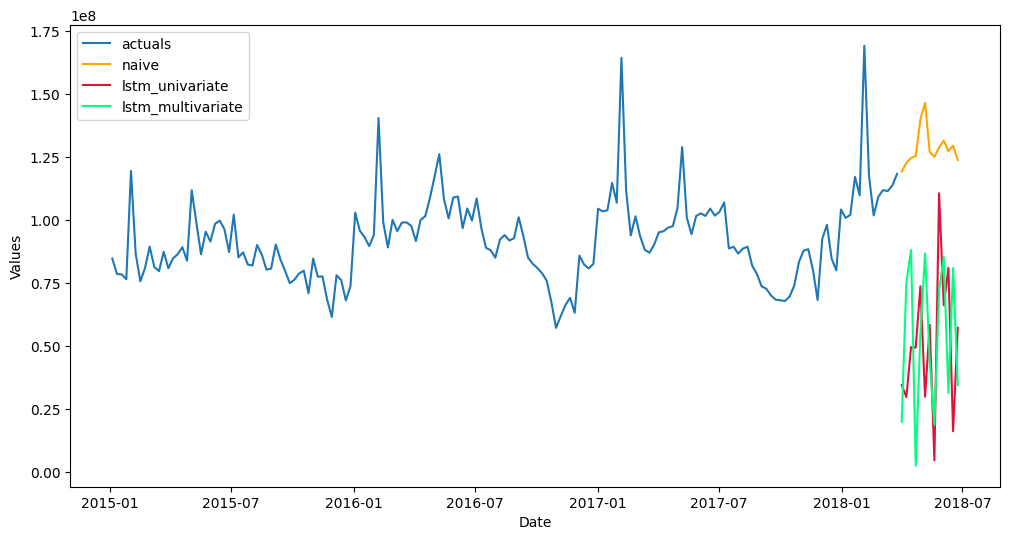

In [18]:
fvol.plot(order_by='TestSetRMSE')
plt.show()

# Probabilistic Forecasting

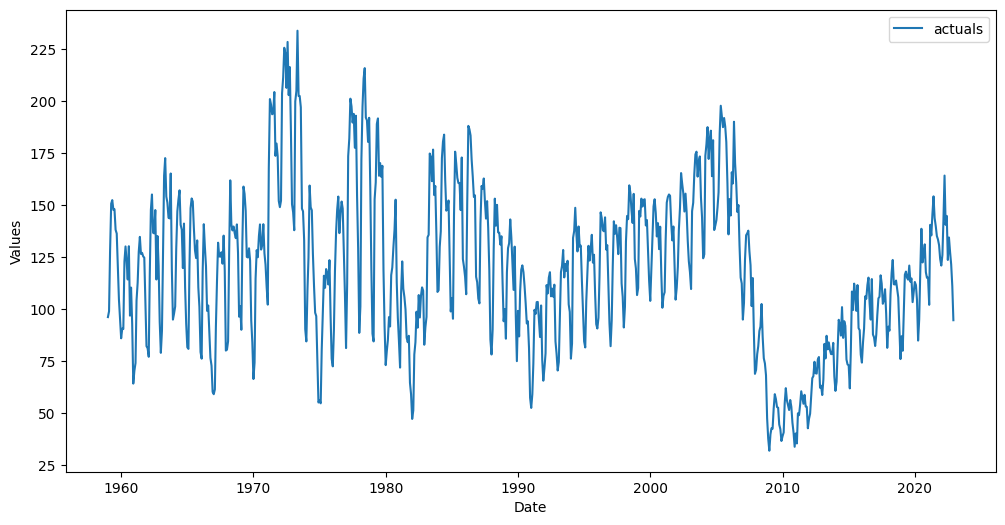

In [19]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2022-12-31',
)

f = Forecaster(
    y = df['HOUSTNSA'],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
    test_length = .1, # 10% test length
    cis = True,
    cilevel = .9, # 90% intervals
)

f.plot()
plt.show()

In [20]:
transformer, reverter = find_optimal_transformation(
    f,
    estimator = 'lstm',
    epochs = 10,
    set_aside_test_set=True, # prevents leakage so we can benchmark the resulting models fairly
    return_train_only = True, # prevents leakage so we can benchmark the resulting models fairly
    verbose=True,
    m = 52, # what makes one seasonal cycle?
    test_length = 24,
    num_test_sets = 3,
    space_between_sets = 12,
    detrend_kwargs=[
        {'loess':True},
        {'poly_order':1},
        {'ln_trend':True},
    ],
)

Using lstm model to find the best transformation set on 3 test sets, each 24 in length.
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4317
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4060 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3850
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3606 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3309 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2985 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2641
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2279 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2023
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4353
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4066
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3862
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3551
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3126
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2789
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2319 
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2003
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1711
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1590
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4278
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4086  
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3890 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3605 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3335  
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3031 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2685 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2391 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2131 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1863 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4419
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4240 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3956  
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3657 
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3327  
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2936 
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2540  
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2116 
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1830 
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1596 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4230
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4059
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3852
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3601
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3357
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3060
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2691
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2411
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2130
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1903
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4574
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4244
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3988
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3626
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3295  
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2963
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2550
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2119
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1869
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1661
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Last transformer tried:
[]
Score (rmse): 24.54664811066405
--------------------------------------------------
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4556
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4427
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4180
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3901
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3586
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3313
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2966 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2611
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2271
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1980
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4495
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4247 
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3813 
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3611
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3227
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2830
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2474
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2053 
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1727
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1607  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4539
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4355  
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4168 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3988 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3625 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3342 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3006 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2662
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2359
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2054
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4340
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4193
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3802
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3481
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3056
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2638
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2234  
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1965
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1746 
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4516
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4351 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4084 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3861  
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3586 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3268  
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2938  
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2589 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2267 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4452
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4136 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3902 
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3441 
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3030 
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2631 
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2257 
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1923 
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1711
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1575
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (rmse): 22.66280755757398
--------------------------------------------------
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4501
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4276
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4010
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3828
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3542
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3169
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2881
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2536 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2216 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1966 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4212
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4020 
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3669
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3327
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2954
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2640
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2345
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2064
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1854
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1695
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4440
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4275 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4009 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3752 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3565
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3312
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3021
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2680
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2375
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2097
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.4177
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3898
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3550
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3231  
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2937 
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2624  
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2281 
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2098
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1858 
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1716 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4332
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4156 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3968 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3724
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3483
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3207
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2867 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2529
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2286
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1993
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.4273
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4088
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3842
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3507
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3194
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2857
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2511
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2143  
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1926
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (rmse): 18.16947855724386
--------------------------------------------------
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4344 
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4111 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3897 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3650 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3318
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3005 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2298 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2068 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4464
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4121
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3801
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3491
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3200
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2853
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2465
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2062
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1789
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1603
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4292 
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4114
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3859
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3568
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3352
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3050
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2719  
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2423 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2103 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1898 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4383
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4207 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3887 
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3649 
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3231
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2852
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2535
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2167
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1828
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1657
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.4275
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4073
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3889
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3673
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3420
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3156
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2860
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2572
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2246
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2028
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4438 
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4245 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3936
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3551
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3355  
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2934
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2582
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2268
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1955
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1718
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Last transformer tried:
[('DetrendTransform', {'ln_trend': True})]
Score (rmse): 21.236829285886667
--------------------------------------------------
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4637
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4502
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4194
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3916
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3637
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3251
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2876
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2515
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2248 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1939  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4482
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4077
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3911
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3608
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3421
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3008
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2692
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2324
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2084
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4791
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4626
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4329
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4178
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3892
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3573
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3225
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2816
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2489
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2199
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4582
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4349 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4015 
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3649 
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3401 
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2982 
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2244 
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2008 
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1880 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4848
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4702 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4476 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4207  
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3952 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3600 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3283
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2870 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2542 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4712
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4460
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4275
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4018
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3600
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3250
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2960
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2530
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2130
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (rmse): 14.219334537184125
--------------------------------------------------
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4332
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4110 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3869 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3596 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3293 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2942 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2538 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2128  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1768 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1507 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4328
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4059
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3750
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3415
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3000 
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2534
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2053
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1641
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1359
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4286
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4091 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3882
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3652
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3389
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3077 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2725
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2349
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1962
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1637 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4270
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4020
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3745
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3432
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3081
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2662
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2211
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1793
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1465
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1279
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4347
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4140 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3917 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3670 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3390 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3079
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2737
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2376  
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1991 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4317
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4030 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3735 
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3396  
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3014 
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2585 
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2152 
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1777
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1511 
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1367 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'}), ('DiffTransform', 1)]
Score (rmse): 88.04789210633908
--------------------------------------------------
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5057
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4857 
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4663 
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4512 
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4214 
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3967 
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3667 
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3375 
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2995 
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2652  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4986
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4708
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4387
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4206
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3815
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3586
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3090
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2706
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2389
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5017
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4790 
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4598 
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4390 
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4126 
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3855 
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3543 
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3252 
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2863 
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2517 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4882
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4775 
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4458 
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4149 
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3857
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3412 
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3032
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2198 
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1853 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4968
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4828 
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4588 
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4336 
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4128 
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3888  
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3595 
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3253  
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2969  
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2614  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4964
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4718
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4445
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4254 
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3897 
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3515 
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3163
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2751
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2366
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'}), ('DiffTransform', 52)]
Score (rmse): 69.66992092404331
--------------------------------------------------
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4625
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4580 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4240 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3979 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3689 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3336 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2983
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2608
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2239 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4313
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4169  
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3860 
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3539
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3103
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2760 
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2455
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2096 
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1799
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1669 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4731
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4572
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4391
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4075 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3834
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3537 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3091
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2790
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2457 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2158  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4676
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4404 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4095
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3847
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3592 
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3200 
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2848
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2504
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2234
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1961
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4888
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4621 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4404  
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4209 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3860 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3588 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3151 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2815  
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2483
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2138 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4712
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4448
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4150
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3859
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3608
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3236
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2826
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2533
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2061
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'}), ('ScaleTransform',)]
Score (rmse): 15.673965990429053
--------------------------------------------------
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4591
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4412
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4183
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3888
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3563
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3203 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2811 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2504 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2172
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4483
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4144
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3883 
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3506
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3156
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2889
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2559
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2208
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1963
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1743
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4758
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4528
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4356
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4074
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3865
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3483
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3150
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2780
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2412
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2096
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4533
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4282 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3964 
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3568 
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3256 
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2831
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2436
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2177
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1942
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1720
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4812
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4662 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4481 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4231 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3980 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3649 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3330 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2929 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2555 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2216 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4653
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4471 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4168
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3996
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3594 
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3149
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2826 
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2360 
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2049
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'}), ('MinMaxTransform',)]
Score (rmse): 14.998283596513604
--------------------------------------------------
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4698
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4419
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4227 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3944
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3685
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3337
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2962 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2585 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2270
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4358
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4171 
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3730 
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3511 
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3180 
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2812
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2470
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2007
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1816
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4826
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4680 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4404 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4197 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3963
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3738 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3381
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3038
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2623
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2290
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4525
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4180 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3966
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3599 
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3211 
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2918 
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2491 
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2159 
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1933
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4842
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4657  
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4478  
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4235 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3911 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3590 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3239 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2831
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2455
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2156 
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4685
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4466
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4296
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3851
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3550
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3164
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2839
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2491
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2210
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'}), ('RobustScaleTransform',)]
Score (rmse): 14.463660163942572
--------------------------------------------------
Final Selection:
[('DetrendTransform', {'poly_order': 1, 'train_only': True}), ('DeseasonTransform', {'m': 52, 'model': 'add', 'train_only': True})]


In [21]:
rnn_grid = gen_rnn_grid(
    layer_tries = 100,
    min_layer_size = 1,
    max_layer_size = 5,
    units_pool = [100],
    epochs = [100],
    dropout_pool = [0,0.05],
    validation_split=.2,
    callbacks=EarlyStopping(
      monitor='val_loss',
      patience=3,
    ),
    random_seed = 20,
) # make a really big grid and limit it manually

In [22]:
def forecaster(f,grid):
    f.auto_Xvar_select(
        try_trend=False,
        try_seasonalities=False,
        max_ar=100
    )
    f.set_estimator('rnn')
    f.ingest_grid(grid)
    f.limit_grid_size(10) # randomly reduce the big grid to 10
    f.cross_validate(k=3,test_length=24) # three-fold cross-validation
    f.auto_forecast()

In [23]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f = pipeline.fit_predict(f,grid=rnn_grid)


output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 10, 1), dtype=float32, sparse=None, name=keras_tensor_292>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 10, 1), dtype=float32, sparse=None, name=keras_tensor_293>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 10, 1), dtype=float32, sparse=None, name=keras_tensor_294>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 10, 1), dtype=float32, sparse=None, name=keras_tensor_295>',)
  • kwargs={'training': 'False', 'mask': 'None'}

output_size must be an integer.

Arguments received by LSTM.call():
  • args=('<KerasTensor shape=(None, 10, 1), dtype=float32, spa

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


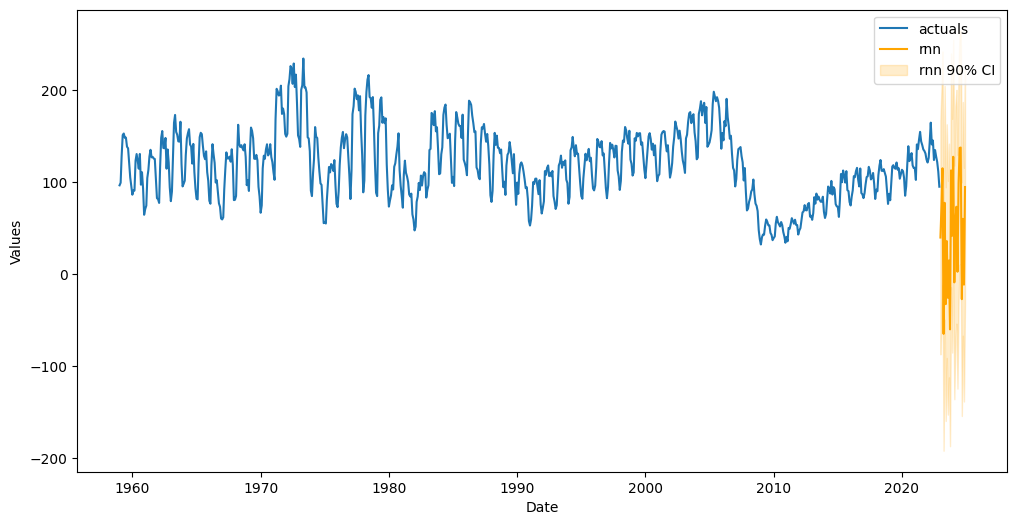

In [24]:
f.plot(ci=True)
plt.savefig('Probabilistic LSTM.png')
plt.show()

# Dynamic Probabilistic Forecasting

In [25]:
params = f.best_params
num_chosen_lags = len(f.get_regressor_names())

In [26]:
def forecaster(f,params):
    f.set_estimator('rnn')
    f.manual_forecast(**params,test_again=False,lags=num_chosen_lags)

In [27]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

In [28]:
f = pipeline.fit_predict(f,params = params)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [38]:
backtest_results = backtest_for_resid_matrix(
    f,
    pipeline=pipeline,
    alpha = .1,
    jump_back = 12,
    params = f.best_params,
)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3931
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.5283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4894
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5090
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4525
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4441
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5248
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [39]:
backtest_resid_matrix = get_backtest_resid_matrix(backtest_results)

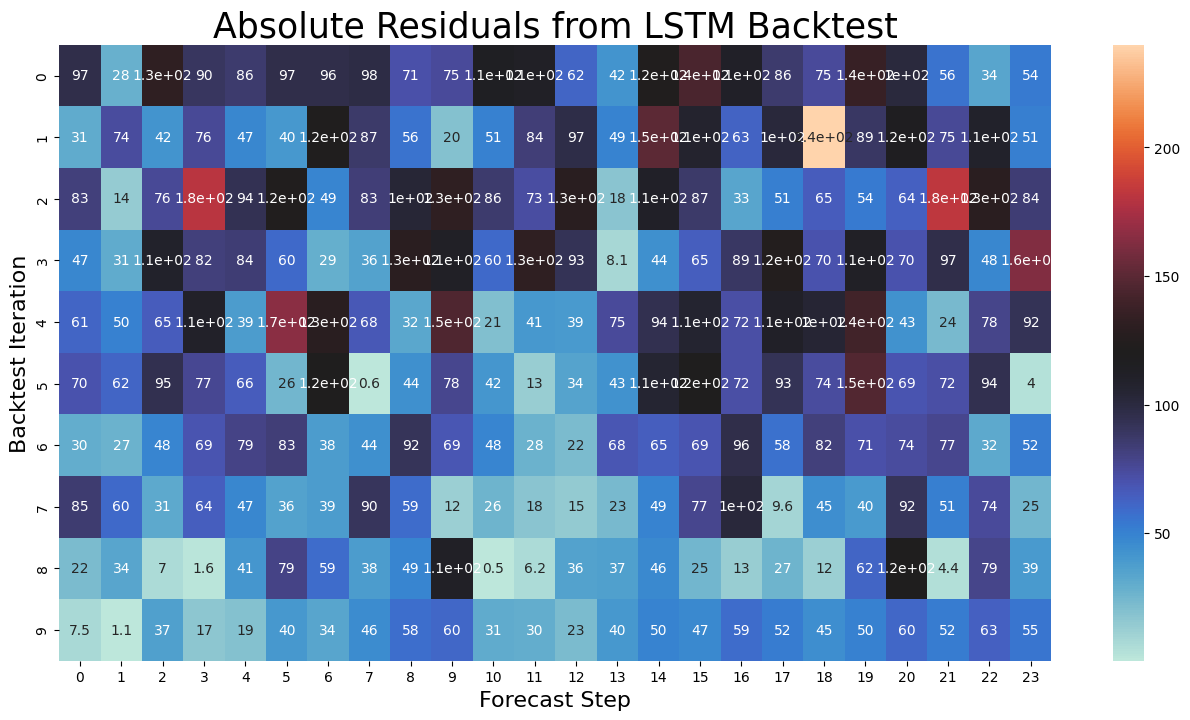

In [40]:
pd.options.display.max_columns = None
fig, ax = plt.subplots(figsize=(16,8))
mat = pd.DataFrame(np.abs(backtest_resid_matrix[0]['rnn']))
sns.heatmap(
    mat.round(1),
    annot = True,
    ax = ax,
    cmap = sns.color_palette("icefire", as_cmap=True),
)
plt.ylabel('Backtest Iteration',size=16)
plt.xlabel('Forecast Step',size = 16)
plt.title('Absolute Residuals from LSTM Backtest',size=25)
plt.savefig('LSTM Resid Matrix.png')
plt.show()

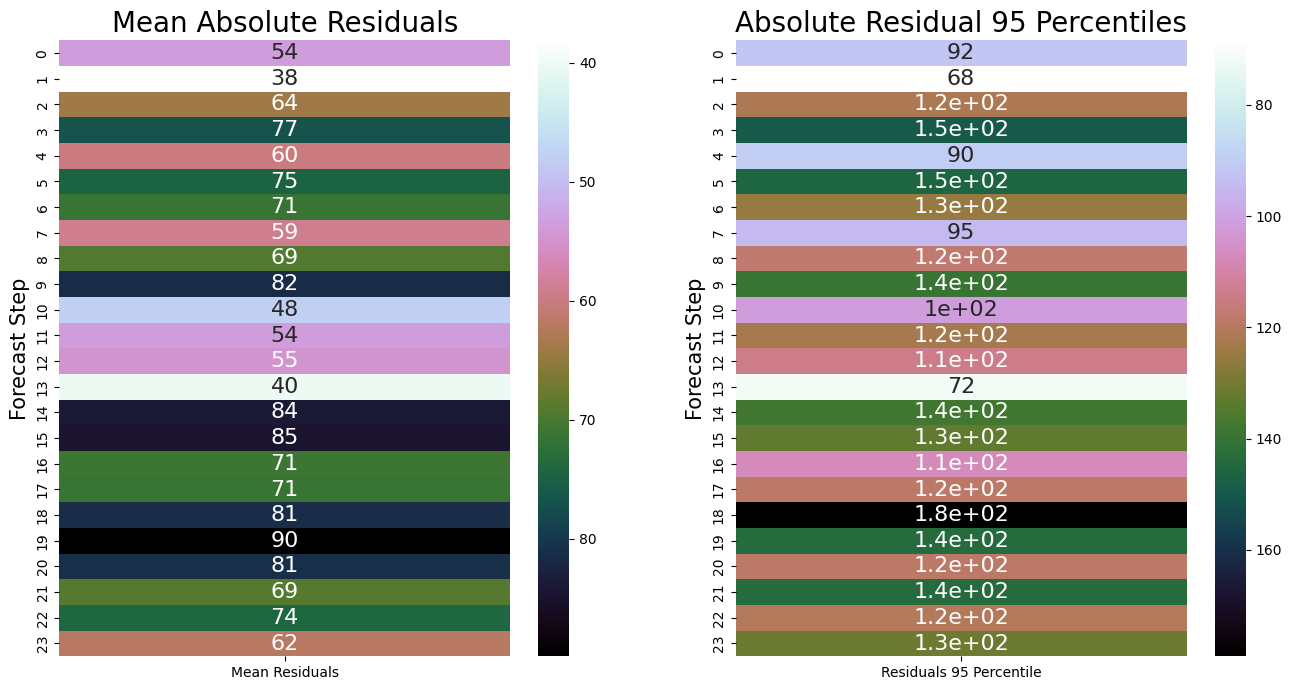

In [41]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.heatmap(
    pd.DataFrame({'Mean Residuals':mat.mean().round(1)}),
    annot = True,
    cmap = 'cubehelix_r',
    ax = ax[0],
    annot_kws={"fontsize": 16},
)
cbar = ax[0].collections[0].colorbar
cbar.ax.invert_yaxis()
ax[0].set_title('Mean Absolute Residuals',size=20)
ax[0].set_ylabel('Forecast Step',size=15)
ax[0].set_xlabel('')
sns.heatmap(
    pd.DataFrame({'Residuals 95 Percentile':np.percentile(mat, q=95, axis = 0)}),
    annot = True,
    cmap = 'cubehelix_r',
    ax = ax[1],
    annot_kws={"fontsize": 16},
)
cbar = ax[1].collections[0].colorbar
cbar.ax.invert_yaxis()
ax[1].set_title('Absolute Residual 95 Percentiles',size=20)
ax[1].set_ylabel('Forecast Step',size=15)
ax[1].set_xlabel('')
plt.show()

In [42]:
overwrite_forecast_intervals(f,backtest_resid_matrix=backtest_resid_matrix,alpha=.1)

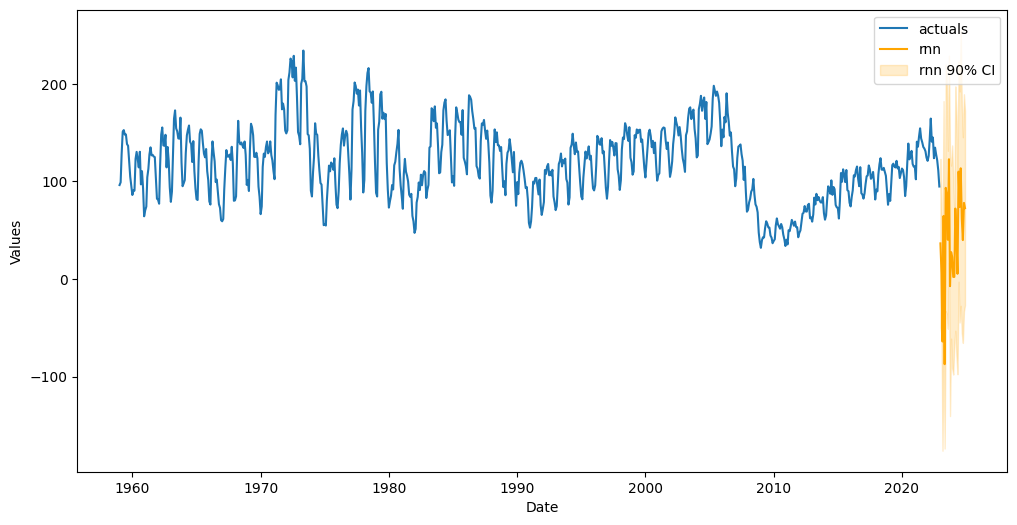

In [43]:
f.plot(ci=True)
plt.savefig('LSTM dynamic intervals.png')
plt.show()

# Transfer Learning

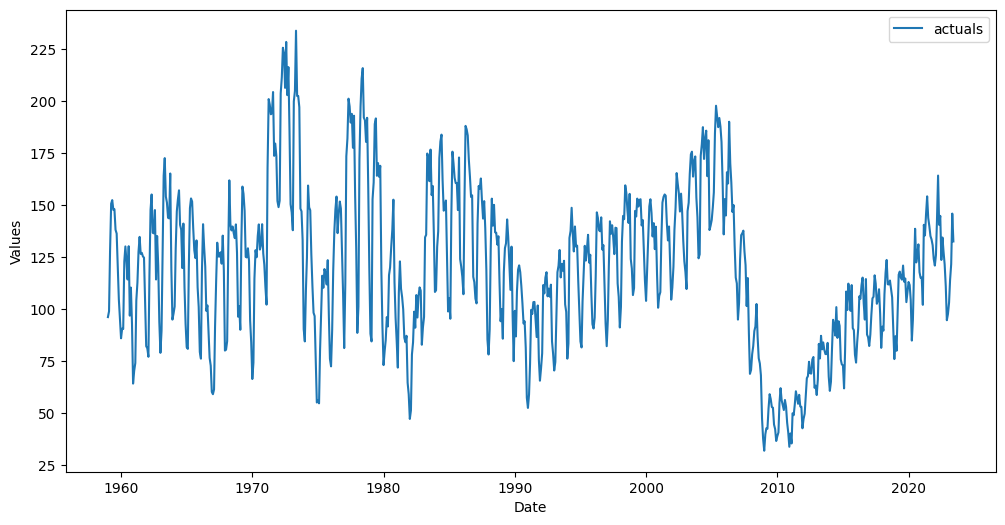

In [30]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2023-06-30',
)

f_new = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
)

f_new.plot()
plt.show()

In [31]:
def transfer_forecast(f_new,transfer_from):
    f_new = infer_apply_Xvar_selection(
        infer_from=transfer_from,
        apply_to=f_new
    )
    f_new.transfer_predict(
        transfer_from=transfer_from,
        model='rnn',
        model_type='tf'
    )

In [32]:
pipeline_can = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Transfer Forecast',transfer_forecast),
        ('Revert',reverter),
    ]
)

f_new = pipeline_can.fit_predict(f_new,transfer_from=f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


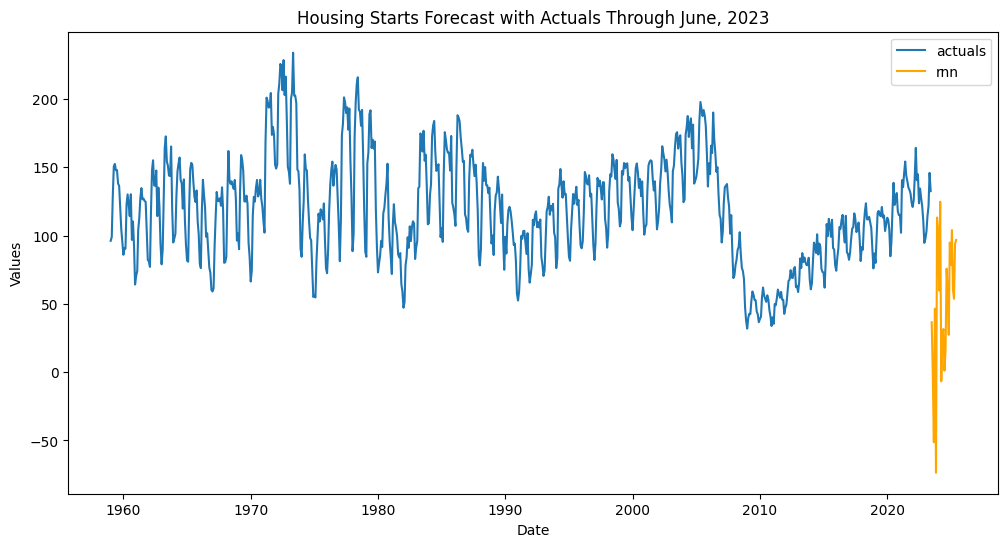

In [33]:
f_new.plot()
plt.title('Housing Starts Forecast with Actuals Through June, 2023')
plt.savefig('RNN transferred same series.png')
plt.show()

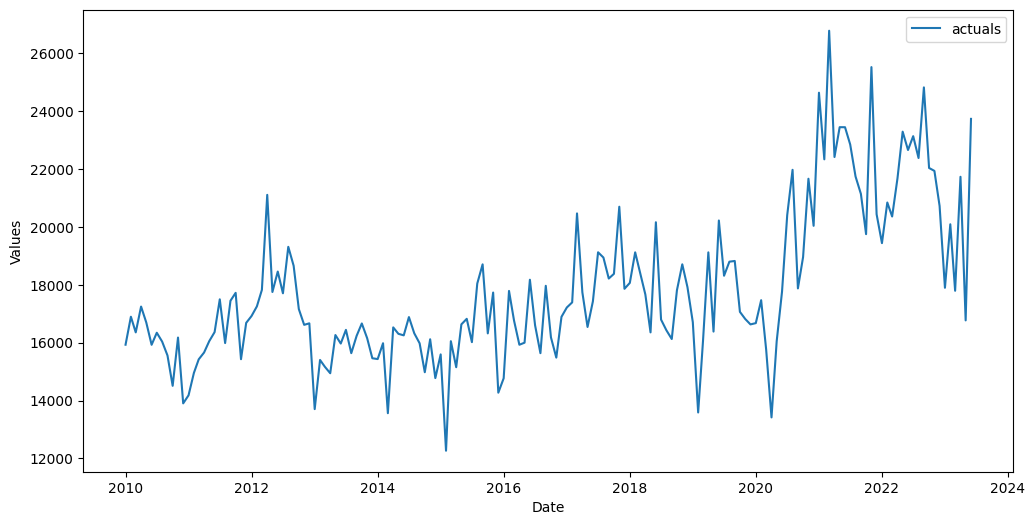

In [34]:
df = pdr.get_data_fred(
    'CANWSCNDW01STSAM',
    start = '2010-01-01',
    end = '2023-06-30',
)

f_new = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
)

f_new.plot()
plt.show()

In [35]:
def transfer_forecast(f_new,transfer_from):
    f_new = infer_apply_Xvar_selection(
        infer_from=transfer_from,
        apply_to=f_new
    )
    f_new.transfer_predict(
        transfer_from=transfer_from,
        model='rnn',
        model_type='tf'
    )

In [36]:
pipeline_can = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Transfer Forecast',transfer_forecast),
        ('Revert',reverter),
    ]
)

f_new = pipeline_can.fit_predict(f_new,transfer_from=f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


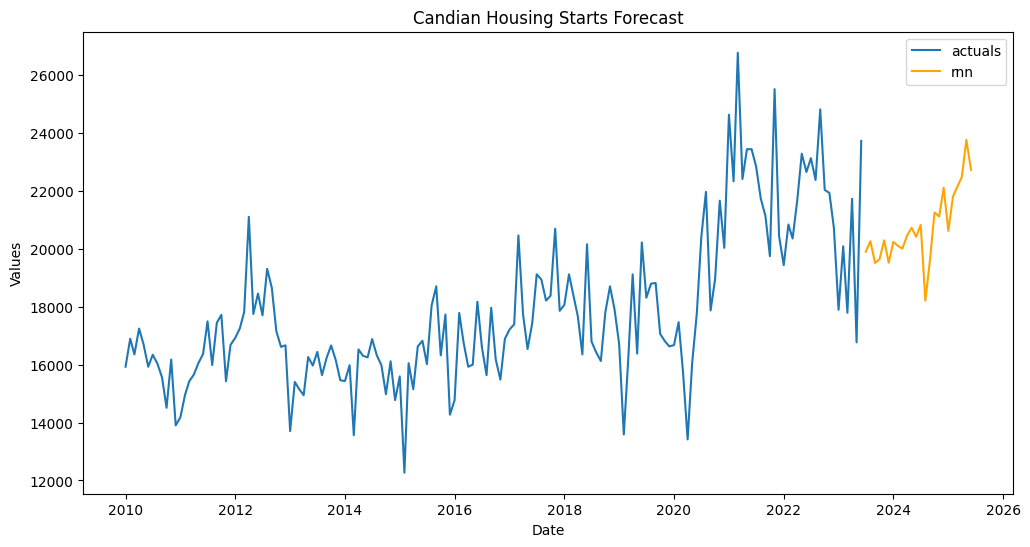

In [37]:
f_new.plot()
plt.title('Candian Housing Starts Forecast')
plt.savefig('Transferred RNN Canada')
plt.show()